In [55]:
import tfim
import tfim_perturbation
import numpy as np
from scipy import sparse
from scipy.sparse import linalg as spla
from scipy import linalg
import matplotlib.pyplot as plt
from scipy import optimize
import progressbar

In [56]:
PBC = True
L = [4]
J = 1

In [57]:
# Build lattice and basis
###################################
lattice = tfim.Lattice(L, PBC)
N = lattice.N
basis = tfim.IsingBasis(lattice)
###################################

In [58]:
#construct random J matrix
Jij = tfim.Jij_instance(N,J,"bimodal",0) 

In [59]:
# List out all the spin_states, corresponding indices and energies
Energies = -tfim.JZZ_SK_ME(basis,Jij)
for index in range(2**N):
    print index, basis.state(index), Energies[index]

0 [0 0 0 0] -0.0
1 [0 0 0 1] 6.0
2 [0 0 1 0] -2.0
3 [0 0 1 1] -0.0
4 [0 1 0 0] -2.0
5 [0 1 0 1] -0.0
6 [0 1 1 0] -0.0
7 [0 1 1 1] -2.0
8 [1 0 0 0] -2.0
9 [1 0 0 1] -0.0
10 [1 0 1 0] -0.0
11 [1 0 1 1] -2.0
12 [1 1 0 0] -0.0
13 [1 1 0 1] -2.0
14 [1 1 1 0] 6.0
15 [1 1 1 1] -0.0


In [60]:
# Find the GS energies, indices and construct H_0

GS_energy, GS_indices = tfim_perturbation.GS(Energies)

# Construct a list of ground state indices stored in GS_indices and a list
#of ground state energies stored in GS_energy

H_app_0 = tfim_perturbation.H_app_0(GS_energy, GS_indices)

In [61]:
# Find excited states (to be cut)

ES_indices = [];
ES_state = [];
for i in range(2**N):
    if i not in GS_indices:
        ES_indices.append(i)

for i in ES_indices:
    ES_state.append(list(basis.state(i)))

In [62]:
# First-Order term in perturbation theory

H_app_1 = tfim_perturbation.H_app_1(basis, GS_indices, N)

In [63]:
# Second-Order term in perturbation theory

H_app_2 = tfim_perturbation.H_app_2(basis, Jij, GS_indices, N, GS_energy)

In [64]:
# Build exact Hamiltonian
V_exact = np.zeros((basis.M, basis.M))

for ket in range(basis.M):
    state = basis.state(ket)
    for i in range(lattice.N):
        basis.flip(state,i)
        bra = basis.index(state)
        V_exact[bra, ket] += 1
        basis.flip(state,i)

H_0_exact = np.diag(Energies)

def H_exact(h_x):
    return H_0_exact - h_x*V_exact

In [65]:
# Specify range of h_x

h_x_range = np.arange(0, 0.1, 0.001)

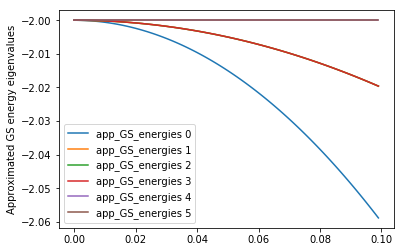

In [66]:
# Calculate and plot approximated GS energy for different values of h_x

# Calculate eigenvalues and eigenstates for range(h_x)

app_eigenvalues = np.zeros((len(GS_indices), len(h_x_range)))
app_eigenstates = np.zeros((len(h_x_range), len(GS_indices), len(GS_indices)))

for j, h_x in enumerate(h_x_range):
    app_eigenvalue, app_eigenstate = np.linalg.eigh(tfim_perturbation.H_app(h_x, H_app_0, H_app_1, H_app_2, J));
    for i in range(len(GS_indices)):
        app_eigenvalues[i][j] = app_eigenvalue[i]
        for k in range(len(GS_indices)):
            app_eigenstates[j][i][k] = app_eigenstate[i][k]
            
for i in range(len(GS_indices)):
    app_GS_energy_plot = plt.plot(h_x_range, app_eigenvalues[i], label = 'app_GS_energies ' + str(i))
    plt.legend()
plt.ylabel("Approximated GS energy eigenvalues")
plt.show(app_GS_energy_plot)

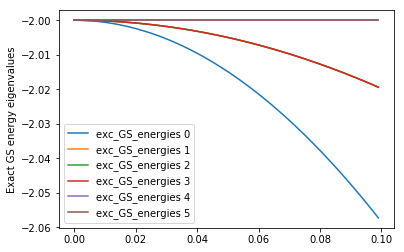

In [67]:
# Calculate and plot exact energy eigenvalues and eigenstates for range(h_x)

exc_eigenvalues = np.zeros((basis.M, len(h_x_range)))
exc_eigenstates = np.zeros((len(h_x_range), basis.M, basis.M))

for j, h_x in enumerate(h_x_range):
    exc_eigenvalue, exc_eigenstate = np.linalg.eigh(H_exact(h_x));
    for i in range(basis.M):
        exc_eigenvalues[i][j] = exc_eigenvalue[i]
        for k in range(basis.M):
            exc_eigenstates[j][i][k] = exc_eigenstate[i][k]
            
for i in range(len(GS_indices)):
    exc_GS_energy_plot = plt.plot(h_x_range, exc_eigenvalues[i], label = 'exc_GS_energies ' + str(i))
    plt.legend()
    
plt.ylabel("Exact GS energy eigenvalues")
plt.show(exc_GS_energy_plot)

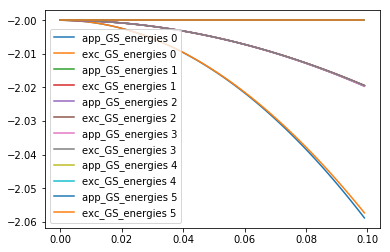

In [68]:
# Compare the exact and approximated GS energies

for i in range(len(GS_indices)):
    plt.plot(h_x_range, app_eigenvalues[i], label = 'app_GS_energies ' + str(i))
    plt.plot(h_x_range, exc_eigenvalues[i], label = 'exc_GS_energies ' + str(i))
    plt.legend()

[ 0.08539764 14.81754312]
[0.00387448 1.9244569 ]
[0.00387448 1.9244569 ]
[0.00387448 1.92445691]
[ 1.34095191e-11 -1.30564912e-10]
[ 1.59910252e-11 -1.57855819e-10]


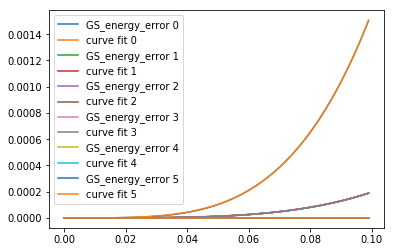

In [69]:
# Calculate and plot energy errors

corrected_exc_eigenvalues = np.zeros((len(GS_indices), len(h_x_range)))

for i in range(len(GS_indices)):
    for j in range(len(h_x_range)):
        corrected_exc_eigenvalues[i, j] = exc_eigenvalues[i, j]

error_array = np.absolute(corrected_exc_eigenvalues - app_eigenvalues)

# Curve fit

def poly_4(x, b, c):
    return b*x**3 + c*x**4;

for i in range(len(GS_indices)):
    popt, pcov = optimize.curve_fit(poly_4, h_x_range, error_array[i])
    print popt
    GS_energy_error_plot = plt.plot(h_x_range, error_array[i], label = 'GS_energy_error ' + str(i))
    curve_fit = plt.plot(h_x_range, poly_4(h_x_range, *popt), label = 'curve fit ' + str(i))
    plt.legend()


In [70]:
# Calculate exact and approximate probabilities for each eigenstates

In [71]:
# Define probability for any eigenstates for a given h_x

def prob(eigenstate):
    norm = np.vdot(eigenstate, eigenstate)
    normed_eigenstate = eigenstate/(norm**0.5)
    return np.conjugate(normed_eigenstate)*normed_eigenstate

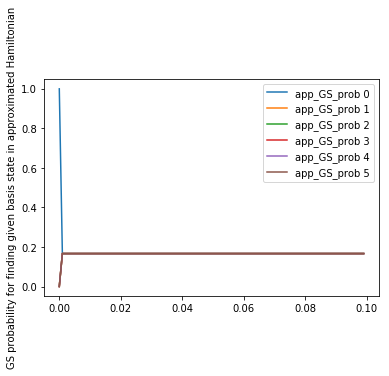

In [72]:
# Calculate probabilities for approximated eigenstates

prob_app = np.zeros((len(GS_indices), len(h_x_range),))

for j, h_x in enumerate(h_x_range):
    GS_prob_vector = prob(app_eigenstates[j][:, 0])
    for i in range(len(GS_indices)):
        prob_app[i][j] = GS_prob_vector[i]

# Plot probabilities for finding six bases states for system in ground eigenstate (approximated)

for i in range(len(GS_indices)):
    app_GS_probability_plot = plt.plot(h_x_range, prob_app[i], label = 'app_GS_prob ' + str(i))
    plt.legend()
plt.ylabel("GS probability for finding given basis state in approximated Hamiltonian")
plt.show(app_GS_probability_plot)

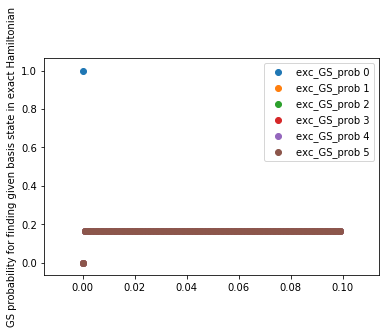

In [73]:
# Calculate probabilities for exact eigenstates

prob_exc = np.zeros((len(GS_indices), len(h_x_range),))

for j, h_x in enumerate(h_x_range):
    GS_prob_vector = prob(exc_eigenstates[j][:, 0])
    for k, i in enumerate(GS_indices):
        prob_exc[k][j] = GS_prob_vector[i]

# Plot probabilities for finding six bases states for system in ground eigenstate (exact)

for i in range(len(GS_indices)):
    exc_GS_probability_plot = plt.scatter(h_x_range, prob_exc[i], label = 'exc_GS_prob ' + str(i))
    plt.legend()
plt.ylabel("GS probability for finding given basis state in exact Hamiltonian")
plt.show(exc_GS_probability_plot)

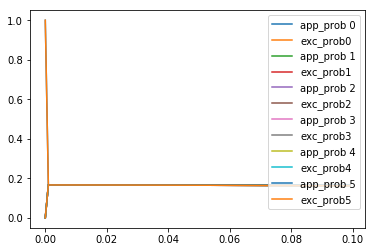

In [74]:
# Compare probabilities

for i in range(len(GS_indices)):
    plt.plot(h_x_range, prob_app[i], label = 'app_prob ' + str(i))
    plt.plot(h_x_range, prob_exc[i], label = 'exc_prob' + str(i))
    plt.legend(loc = 'upper right')

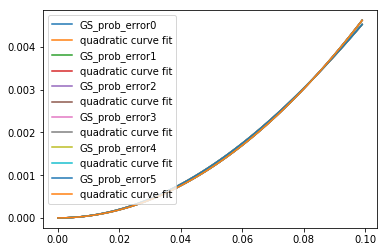

In [75]:
# Calculate and plot probability errors

prob_error_array = np.absolute(prob_app - prob_exc)

# Curve fit

def poly_2(x, a):
    return a*x**2;

for i in range(len(GS_indices)):
    popt, pcov = optimize.curve_fit(poly_2, h_x_range, prob_error_array[i])
    GS_probability_error_plot = plt.plot(h_x_range, prob_error_array[i], label = 'GS_prob_error' + str(i))
    curve_fit = plt.plot(h_x_range, poly_2(h_x_range, *popt), label = 'quadratic curve fit')
    plt.legend()

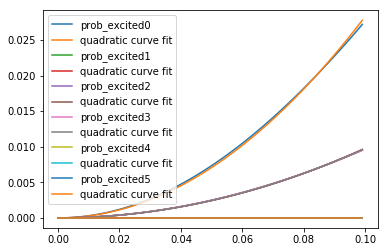

In [76]:
# Total probability of the excited states for all six eigenvectors as a function of h_x (exact)
prob_exc_total = np.zeros((len(GS_indices), len(GS_indices), len(h_x_range)))

for n in range(len(GS_indices)):
    for j, h_x in enumerate(h_x_range):
        GS_prob_vector = prob(np.transpose(exc_eigenstates[j])[n])
        for k, i in enumerate(GS_indices):
            prob_exc_total[n][k][j] = GS_prob_vector[i]

prob_excited_sum = np.zeros((len(GS_indices), len(h_x_range)))

for n in range(len(GS_indices)):
    for i, h_x in enumerate(h_x_range):
        prob_excited_sum[n][i] = 1 - np.sum(prob_exc_total[n][:, i])

for i in range(len(GS_indices)):
    popt, pcov = optimize.curve_fit(poly_2, h_x_range, prob_excited_sum[i])
    plt.plot(h_x_range, prob_excited_sum[i], label = 'prob_excited' + str(i))
    plt.plot(h_x_range, poly_2(h_x_range, *popt), label = 'quadratic curve fit')
    plt.legend()

In [77]:
# Plot fidelity

# Renormalize
def normalize(eigenstate):
    norm = np.vdot(eigenstate, eigenstate)**0.5
    return eigenstate/norm

# Extract ground states from exc_states matrix and renormalize

GS_exc_eigenstates = np.zeros((len(h_x_range), len(GS_indices), len(GS_indices)))
normalized_GS_exc_eigenstates = np.zeros((len(h_x_range), len(GS_indices), len(GS_indices)))

for j in range(len(h_x_range)):
    for n, m in enumerate(GS_indices):
        for i, k in enumerate(GS_indices):
            GS_exc_eigenstates[j, n, i] = exc_eigenstates[j, m, i]
            
for j in range(len(h_x_range)):
    for n in range(len(GS_indices)):
        normed_vector = normalize(GS_exc_eigenstates[j, :, n])
        for i in range(len(GS_indices)):
            normalized_GS_exc_eigenstates[j, i, n] = normed_vector[i]
            
# Fidelity

def fidelity(exc_eigenstate, app_eigenstate):
    dot = np.vdot(exc_eigenstate, np.conjugate(app_eigenstate))
    return dot*np.conjugate(dot)

In [78]:
# identify degenerate energy level and resort

epsilon = 1*10**(-12)

def sort(lst):
    order = [];
    floor = np.array([0]);
    for i in range(1, len(lst)):
        if abs(lst[i-1] - lst[i]) <= epsilon:
            floor = np.append(floor, i)
        else:  
            order.append(floor)
            floor = np.array([i]);
    order.append(floor)
    return list(order) 

In [86]:
GS_exc_eigenvalues = exc_eigenvalues[0:6]
fidelity_array = np.zeros((len(GS_indices), len(h_x_range)))

for i in range(len(h_x_range)):
    sorted_exc_energy_indices = sort(GS_exc_eigenvalues[:, i])
    sorted_app_energy_indices = sort(app_eigenvalues[:, i])
    for l, app_level in enumerate(sorted_app_energy_indices):
        for j in app_level:
            fidel_sum = 0;
            for k in sorted_exc_energy_indices[l]:
                fidel = fidelity(GS_exc_eigenstates[i, :, k], app_eigenstates[i, :, j])
                fidel_sum += fidel
            fidelity_array[j, i] = fidel_sum

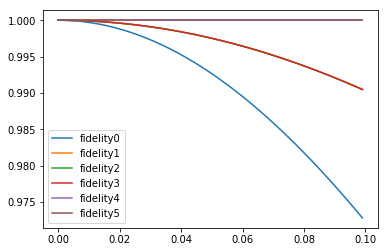

In [87]:
for i in range(len(GS_indices)):
    plt.plot(h_x_range, fidelity_array[i], label = 'fidelity' + str(i))
    plt.legend()

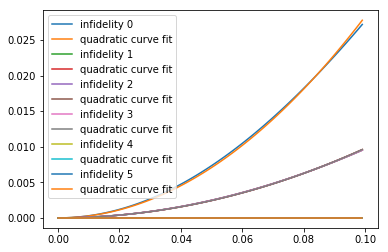

In [88]:
# Infidelity array

infidelity_array = 1 - fidelity_array

for i in range(len(GS_indices)):
    popt, pcov = optimize.curve_fit(poly_2, h_x_range, infidelity_array[i])
    plt.plot(h_x_range, infidelity_array[i], label = 'infidelity ' + str(i))
    plt.plot(h_x_range, poly_2(h_x_range, *popt), label = 'quadratic curve fit')
    plt.legend()